# Utilizing Machine Learning Classification Algorithms to Rank Cheese Fat Content

#### *An Exercise in Exploratory Data Analaysis by Karnjiv Gill*

***

## Introduction

Cheesemaking is a practice that predates recorded history and has been used around the world by many different cultures. There are a large variety of cheeses available to us in the world, everything from cheap and highly processed grocery store cheese, to rich, and meticulously refined artisinal cheese. I will attempt to create a predictive model that scores well and can forecast the fat level of various cheeses.


## Dataset Description 

For this analysis I will be utilizing the `cheese.csv` dataset that has been retrieved through Kaggle and provided using an Open License by the Government of Canada. More specifically I will be assigning the `FatLevel` column as the target and the `ManufacturerTypeEn`,`MilkTypeEn` and `MoisturePercent` columns as features.

## Exploratory Data Analysis

Let us begin by loading in the necessary libraries and the following table: `cheese.csv` 


In [342]:
import altair as alt
import graphviz
import numpy as np
import pandas as pd
import sklearn.linear_model as sk
import string
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR

from scipy.stats import lognorm, loguniform, randint

#alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Below I will display the `cheese.csv` dataframe so that we can take a closer look at the necessary columns for this analysis

In [343]:
#Loading in the dataframe
cheese_df = pd.read_csv('data/cheese.csv')
cheese_df.head(20)

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat
5,350,NB,Industrial,48.0,NaN,Classic fresh cooking cheeses,0,Fresh Cheese,Cow,Pasteurized,NaN,Paneer (Northumberland Co-operative),lower fat
6,374,ON,Industrial,52.0,"Rich, creamy, buttery, both subtle and tangy i...",NaN,0,Soft Cheese,Goat,Pasteurized,Bloomy Rind,Goat Brie (Woolwich),lower fat
7,375,ON,Industrial,41.0,Mild,"Whitem, smooth, firm textured",0,Firm Cheese,Goat,Pasteurized,NaN,Goat Cheddar (Woolwich),lower fat
8,376,ON,Industrial,50.0,Mild,NaN,0,Semi-soft Cheese,Goat,Pasteurized,NaN,Goat Mozarella (Woolwich),lower fat
9,378,ON,Industrial,55.0,"Sharp, tangy, salty",With or without brine,0,Soft Cheese,Goat,Pasteurized,NaN,Goat Feta (Woolwich),lower fat


Next, I will perform some data cleaning by removing the columns that I will not be using in my analysis. 

In [344]:
cheese_clean = cheese_df.drop(columns=['CheeseId','CharacteristicsEn','RindTypeEn','FlavourEn','CheeseName'])
cheese_clean.head(20)

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,lower fat
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,lower fat
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,lower fat
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,lower fat
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,lower fat
5,NB,Industrial,48.0,0,Fresh Cheese,Cow,Pasteurized,lower fat
6,ON,Industrial,52.0,0,Soft Cheese,Goat,Pasteurized,lower fat
7,ON,Industrial,41.0,0,Firm Cheese,Goat,Pasteurized,lower fat
8,ON,Industrial,50.0,0,Semi-soft Cheese,Goat,Pasteurized,lower fat
9,ON,Industrial,55.0,0,Soft Cheese,Goat,Pasteurized,lower fat


Below I have visualized the animals that are producing high fat and low fat cheese. It is interesting to note that a majority of the cheese in this dataset is made using low and high fat Cow's milk, followed by Goat and Ewe milk.

In [385]:
import seaborn as sns

fat_count = cheese_clean.groupby(by=['MilkTypeEn','FatLevel']).size()
fat_count = pd.DataFrame(fat_count).reset_index()
fat_count = fat_count.sort_values(by=0,ascending=False)
fat_count = fat_count.rename(columns={0:'Count'})

sns.barplot(x='MilkTypeEn', y='Count', hue='FatLevel', data=fat_count)


ModuleNotFoundError: No module named 'seaborn'

Before we can begin any sort of data manipulation it is important to perform a split to avoid breaking the golden rule. I will be using an 80/20 split for my train and test data where the target column is `FatLevel` and the features will include `ManufacturerProvCode`,`ManufacturingTypeEn`,`MoisturePercent`,`Organic`,`CategoryTypeEn`,`MilkTypeEn`,
`MilkTreatmentTypeEn`

The features can be subset into the following types: 


The `MilktypeEn`, `ManufacturerProvCode`, `CategoryTypeEn`, `MilkTreatmentTypeEn` and `ManufacturingTypeEn` columns are categorical features

The `Organic` column is a binary feature

The `MoisturePercent` column is a numeric feature

Now I will create my X and y variables by seperating the features and the target

In [346]:
X = cheese_clean.drop(columns='FatLevel')
y = cheese_clean['FatLevel']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=123)

Because there are some null values present, I will utilize `SimpleImputer` with `strategy='most_frequent'` to deal with these

In [347]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_train_imp

X_train_new = pd.DataFrame(X_train_imp)
X_train_new.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

Now that the data has been split and null values have been dealt with through imputation, I will create a `DummyClassifier` to create a baseline score for which we can compare other models with. 

In [348]:
model = DummyClassifier()
model = model.fit(X,y)
model_scores = cross_validate(model, X_train,y_train, cv=5, return_train_score = True)
model_scores = pd.DataFrame(model_scores)
model_scores

,fit_time,score_time,test_score,train_score
0,0.001607,0.000894,0.658683,0.657658
1,0.001273,0.000586,0.658683,0.657658
2,0.001215,0.000603,0.658683,0.657658
3,0.001222,0.000576,0.656627,0.658171
4,0.001192,0.000599,0.656627,0.658171


As we can see the train and test scores are fairly low, so I will use another model to see if the results are any better. First I need to define the categorical, binary and numeric features. 

In [349]:
categorical_features = ['MilkTypeEn','ManufacturerProvCode','CategoryTypeEn','MilkTreatmentTypeEn','ManufacturingTypeEn']
binary_features = ['Organic']
numeric_features = ['MoisturePercent']

Now to build the transformers to make the necessary adjustments to the features.

In [350]:
categorical_transformer = make_pipeline(
                    SimpleImputer(strategy='most_frequent'),
                    OneHotEncoder(handle_unknown='ignore'))

binary_transformer =  make_pipeline(
                    SimpleImputer(strategy='most_frequent'),
                    OneHotEncoder(handle_unknown='ignore'))
            
numeric_transformer = make_pipeline(
                    SimpleImputer(strategy='median'),
                    StandardScaler())

Next, I will build the preprocessor to input into the pipeline. 

In [351]:
preprocessor = make_column_transformer((categorical_transformer,categorical_features),
                                      (binary_transformer,binary_features),
                                      (numeric_transformer, numeric_features))

Building the first pipeline with DecisionTreeClassifier

In [352]:
main_pipe = make_pipeline(preprocessor, DecisionTreeClassifier())

In [353]:
score = cross_val_score(main_pipe, X_train, y_train, cv=5)
score.mean()

0.8007503066156844

It appears that I am not over or underfitting my data judging by the training and test scores, however I feel that I may be able to achieve a better test score so I will try another model

In [354]:
forest_pipe = make_pipeline(preprocessor, RandomForestClassifier())
forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MilkTypeEn',
                                                   'ManufacturerProvCode',
                                                   'CategoryTypeEn',
                                                   'MilkTreatmentTypeEn',
                                                   'ManufacturingTypeEn']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
    

In [355]:
score = cross_validate(forest_pipe, X_train, y_train, cv=5, return_train_score=True)
score = pd.DataFrame(score)
score

,fit_time,score_time,test_score,train_score
0,0.280345,0.024966,0.802395,0.951952
1,0.258597,0.024921,0.814371,0.951952
2,0.260494,0.026575,0.832335,0.947447
3,0.262506,0.024827,0.861446,0.943028
4,0.260142,0.025134,0.819277,0.946027


In [356]:
score.mean()

fit_time       0.264417
score_time     0.025284
test_score     0.825965
train_score    0.948081
dtype: float64

Here we can see that `RandomForestClassifier` has achieved a better score than `DummyTreeClassifier` and that my test scores are now adequate with a mean of 82%

In [357]:
random_pipe = make_pipeline(preprocessor, RandomForestClassifier())

param_grid = {"randomforestclassifier__n_estimators": range(1,15)}

randomizer = GridSearchCV(random_pipe, param_grid, cv=3, verbose=1, n_jobs=-1)
randomizer.fit(X_train, y_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['MilkTypeEn',
                                                                          'ManufacturerProvCode',
                                                                          'CategoryTypeEn',
                                                                          'M

In [376]:
best_params = randomizer.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'randomforestclassifier__n_estimators': 7}


In [381]:
best_model = randomizer.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MilkTypeEn',
                                                   'ManufacturerProvCode',
                                                   'CategoryTypeEn',
                                                   'MilkTreatmentTypeEn',
                                                   'ManufacturingTypeEn']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
    

We can see that the best_params_ method has returned Random Forest Classifier with n_estimators of 7 as the best parameters to use, so I will go ahead and use `.best_estimators_` to utilize this information in my final model. First I will perform CV to see what the model is scoring 

In [384]:
scores = cross_val_score(best_model, X_train, y_train, cv=5)

print("Cross validation scores: ", scores)
print("Average cross validation score: ", scores.mean())


Cross validation scores:  [0.80838323 0.77245509 0.83233533 0.87349398 0.8313253 ]
Average cross validation score:  0.8235985859606089


It appears to be scoring well. Now we will create our confusion matrix.

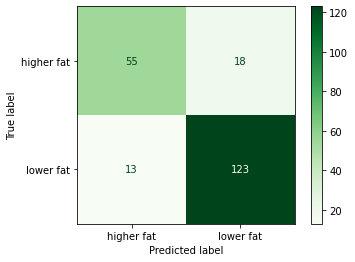

In [382]:
conf_matrix = plot_confusion_matrix(best_model, X_test, y_test, display_labels=np.unique(y_test), cmap='Greens')
plt.show()

And finally, predicting on the test portion of our data

In [383]:
y_pred = best_model.predict(X_test)
y_pred

array(['lower fat', 'lower fat', 'lower fat', 'lower fat', 'lower fat',
       'lower fat', 'higher fat', 'lower fat', 'higher fat', 'lower fat',
       'lower fat', 'lower fat', 'lower fat', 'higher fat', 'higher fat',
       'lower fat', 'lower fat', 'lower fat', 'higher fat', 'higher fat',
       'lower fat', 'lower fat', 'lower fat', 'higher fat', 'lower fat',
       'lower fat', 'lower fat', 'higher fat', 'lower fat', 'higher fat',
       'lower fat', 'lower fat', 'higher fat', 'lower fat', 'higher fat',
       'lower fat', 'lower fat', 'lower fat', 'lower fat', 'lower fat',
       'lower fat', 'higher fat', 'lower fat', 'lower fat', 'lower fat',
       'lower fat', 'lower fat', 'higher fat', 'lower fat', 'lower fat',
       'lower fat', 'lower fat', 'lower fat', 'lower fat', 'lower fat',
       'lower fat', 'lower fat', 'higher fat', 'higher fat', 'lower fat',
       'higher fat', 'lower fat', 'lower fat', 'lower fat', 'lower fat',
       'higher fat', 'higher fat', 'lower fat', 

## Discussion

To conclude, the machine learning model that I have created has utilized the test data that we seperated at the beginning of our analysis to make predictions about the fat content of the various cheeses. The RandomForestClassifier performed well when compared to the DecisionTreeClassifier. There was also a substantial improvement when comparing the test scores of the RandomForestClassifier to the DummyClassifier that I used as a baseline test. Another interesting question I had that I was unable to answer with my current skillset was whether it was possible to predict a cheeses manufacturer by looking at the fat level, moisture percentage and animal. This would've lead to some interesting analysis about whether a certain type of manufacturer is utilizing a certain type of animal to produce their cheese, or if a certain type of manufacturer produces a cheese with a higher or lower fat content. Furthermore, there is potential with the data to perform geographical analysis, segmenting manufacturers by province and analyzing whether specific provinces prefer a specific type of animal to produce cheese or whether specific provinces have an abundance of industrial, farmstead, or artisinal cheeses being produced. We have just scratched the surface and the possibilities with this data are endless. 




## References

All the work contained in this notebook is original and my own, the provided data folder was used to load in the datasets.